In [1]:
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], T.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

Using gpu device 0: GeForce GTX 1060 6GB (CNMeM is disabled, cuDNN 5105)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


[GpuElemwise{exp,no_inplace}(<CudaNdarrayType(float32, vector)>), HostFromGpu(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.194922 seconds
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761
  1.62323296]
Used the gpu


In [2]:
import os
import h5py
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense

# path to the model weights file.
weights_path = 'data/cnn_weights/vgg16_weights.h5'
top_model_weights_path = 'data/cnn_weights/fc_model.h5'
# dimensions of our images.
img_width, img_height = 100, 100

#train_data_dir = 'data/train'
#validation_data_dir = 'data/validation'
nb_train_samples = 6000
nb_validation_samples = 1000
nb_epoch = 50


Using Theano backend.


In [4]:
# load our faces
import os
import matplotlib.pyplot as plt
from scipy import misc
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from spearman import score_function
import time
from scipy.ndimage import imread
%matplotlib inline
from PIL import Image

all_faces = {int(number[::-1][4:][::-1]): "data/extracted_faces/" + number
                  for number in os.listdir("data/extracted_faces")
                  if number[::-1][:4] == 'gpj.'}

bw = np.array(Image.open(all_faces[1])).astype(float)
bw = bw.mean(axis=2)/255.  # black and white normalized
bw = bw.reshape((-1,))  # 10k features

X = np.zeros((len(all_faces), 10**4))

for i in range(13000):
    if i % 1000==0:
        print i
    im = np.array(Image.open(all_faces[i+1])).astype(float)
    if len(im.shape)>2:
        X[i,:] =  im.mean(axis=2).reshape((-1,))/255.
    else:
        X[i,:] = im.reshape((-1,)) / 255.


# read .csv using pandas
y = pd.read_csv("data/training_outputs.csv", delimiter=";").set_index("ID")
y = y.as_matrix()

# store id's
X_ids = range(1, 13001)

# cut into test, train
X_train, X_test, y_train, y_test = train_test_split(X[0:10000], y, test_size=0.3, random_state=42)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


In [5]:
# add fake RGB channels (otherwise the architecture doesn't work :/)
X_train = X_train.repeat(3, 1).reshape((-1, 3, 100, 100))
X_test = X_test.repeat(3, 1).reshape((-1, 3, 100, 100))

### Train models

In [6]:
# build the VGG16 network
model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))

model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# load the weights of the VGG16 networks
# (trained on ImageNet, won the ILSVRC competition in 2014)
# note: when there is a complete match between your model definition
# and your weight savefile, you can simply call model.load_weights(filename)
assert os.path.exists(weights_path), 'Model weights not found (see "weights_path" variable in script).'
f = h5py.File(weights_path)
for k in range(f.attrs['nb_layers']):
    if k >= len(model.layers):
        # we don't look at the last (fully-connected) layers in the savefile
        break
    g = f['layer_{}'.format(k)]
    weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
    model.layers[k].set_weights(weights)
f.close()
print('Model loaded.')

Model loaded.


In [7]:
bottleneck_features_train = model.predict(X_train.reshape((-1, 3, img_width, img_height)), verbose=1)

7000/7000 [==============================] - 18s       64/7000 [..............................] - ETA: 20s

In [8]:
np.save(open('data/cnn_weights/bottleneck_features_train.npy', 'w'), bottleneck_features_train)

In [9]:
bottleneck_features_validation = model.predict(X_test.reshape((-1, 3, img_width, img_height)), verbose=1)
np.save(open('data/cnn_weights/bottleneck_features_validation.npy', 'w'), bottleneck_features_validation)

3000/3000 [==============================] - 7s       64/3000 [..............................] - ETA: 7s

In [14]:
train_data = np.load(open('data/cnn_weights/bottleneck_features_train.npy'))
train_labels = y_train.reshape((-1,))

validation_data = np.load(open('data/cnn_weights/bottleneck_features_validation.npy'))
validation_labels = y_test.reshape((-1,))

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_squared_error'])

In [29]:
model.fit(train_data, train_labels,
          nb_epoch=50, batch_size=32,
          validation_data=(validation_data, validation_labels))

Train on 7000 samples, validate on 3000 samples
Epoch 1/50
7000/7000 [==============================] - 0s - loss: 18.8555 - mean_squared_error: 18.8555 - val_loss: 15.0236 - val_mean_squared_error: 15.0236 128/7000 [..............................] - ETA: 0s - loss: 18.6153 - mean_squared_error: 18.6153

In [30]:
model.save_weights(top_model_weights_path)

In [31]:
preds_train = model.predict(train_data)
preds_test = model.predict(validation_data)

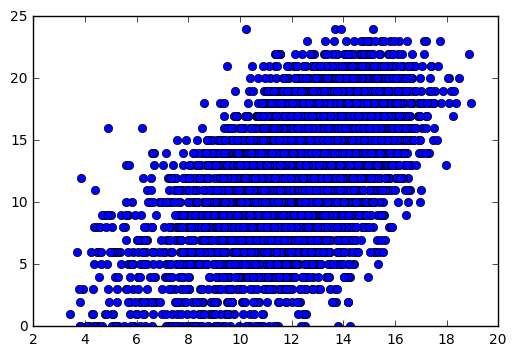

In [32]:
plt.plot(preds_train, y_train, "o")

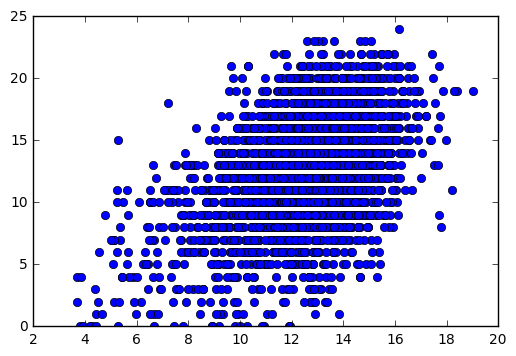

In [33]:
plt.plot(preds_test, y_test, "o")

In [34]:
from spearman import score_function
score_function(y_pred=np.round(preds_test), y_true=y_test)

0.40570015119119762